# Import packages

In [1]:
import os
import numpy as np
# import ipdb
import time
from tqdm import tqdm
import datetime
import pandas as pd
import logging
from pathlib import Path
import matplotlib.pyplot as plt
import math

# torchvision for image loading
import torchvision
from torchvision import datasets, models
import torchvision.transforms.v2 as tr
import torchvision.transforms.v2.functional as trf

from torch.utils.data import DataLoader

# for transformations
import torchvision.transforms.v2 as tr
import torchvision.transforms.v2.functional as trf

# torch for model creation
import torch
import torch.nn as nn

# for model evaluation
import torcheval.metrics.functional as metf
from sklearn.metrics import precision_score, recall_score

#sklearn for data splitting
from sklearn.model_selection import train_test_split

import sys

sys.path.append(os.path.join(os.getcwd(), "Datasetting"))
from Setdata import EcoTaxaDataset, transform_vignettes_valid, FocalLoss, remove_missing_or_empty_images

sys.path.append(os.path.join(os.getcwd(), "PyramidNetPyTorch"))
from PyramidNet import PyramidNet

sys.path.append(os.path.join(os.getcwd(), "Loadingmodels"))
from Loading_models import initialize_model

sys.path.append(os.path.join(os.getcwd(), "Testingmodels"))
from Testing_models import test_model
from Create_confusion_matrix import log_confusion_matrix

# Auto lr finding
from torch_lr_finder import LRFinder

# Import mlflow dor data visualization
import mlflow

/home/coicaudtou/.conda/envs/Classification_UVP6_py310_v2/lib/python3.10/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Import Data

## Config

In [2]:
# Set mlflow
mlflow.set_tracking_uri("http://192.168.77.70:6000")

In [3]:
# root of the project
try:
    base_dir = Path(__file__).resolve().parent
except NameError:
    base_dir = Path("/home/coicaudtou/myspace/Classify_ANERIS")

# relative folders
data_dir = base_dir / "Data"
tsv_path = data_dir / "stacked_anerissmartbay_training.tsv"
output_root = base_dir / "Outputs" / "dataset_split"
train_dir = base_dir / "Outputs"/ "output_training"
log_dir = base_dir / "Outputs" / "log"

RANDOM_STATE = 123

# prepare loggers
log = logging.getLogger()
log.setLevel(logging.INFO)

    # define the output format for log messages
log_formatter = logging.Formatter('%(asctime)s.%(msecs)03d\t%(message)s',\
                                  datefmt='%Y-%m-%dT%H:%M:%S')

    # log to console
console_handler = logging.StreamHandler()
console_handler.setFormatter(log_formatter)
log.addHandler(console_handler)

    # prepare logging to file (activated just before the training loop)
log_file = os.path.join(log_dir, 'log.tsv')
file_handler = logging.FileHandler(log_file)
file_handler.setFormatter(log_formatter)

## Splitting of the data

In [4]:
# ratios des splits
train_ratio, val_ratio, test_ratio = 0.6, 0.2, 0.2

# ---Charger les métadonnées
df = pd.read_csv(tsv_path, sep="\t", engine="python")
# Classes to exclude 
other_to_live = [
    "Trisopterus minutus",
    "reflection",
    "egg sac<egg",
    "t004",
    "Cnidaria<Metazoa",
    "Echinodermata"
]

# Classes to gather to the upper taxonomic group
recode_dict = {
    "Swima": "Annelida",
    "Syngnathiformes": "Actinopterygii",
    "Narcomedusae": "Hydrozoa",
    "Trachymedusae": "Hydrozoa",
    "Appendicularia": "house"
}

# Add to rare classes → "othertocheck"
recode_dict.update({k: "othertocheck" for k in other_to_live})

df = df[
    (df["img_rank"] == 100)
]

# Classes to gather
df["object_annotation_category"] = (
    df["object_annotation_category"]
        .replace(recode_dict)
)
print("Available columns :", df.columns.tolist())

# convert classes to integer indexes
classes = np.unique(df['object_annotation_category'])
class_to_idx = {cls: i for i, cls in enumerate(classes)}
idx_to_class = {i: cls for cls, i in class_to_idx.items()}

# compute class weights
class_counts = df['object_annotation_category'].value_counts().sort_index()
max_count = np.max(class_counts)

# ---Créer les splits
#samples = list(set(df['object_date']))

#samples_train, samples_temp = train_test_split(samples, test_size=(1-train_ratio), random_state= RANDOM_STATE, shuffle=False)
#samples_val, samples_test = train_test_split(samples_temp, test_size=(test_ratio/(test_ratio+val_ratio)), random_state=RANDOM_STATE, shuffle=False)

# ---Créer les DataFrames associés
#train_df = df[df['object_date'].isin(samples_train)].reset_index(drop=True)
#val_df   = df[df['object_date'].isin(samples_val)].reset_index(drop=True)
#test_df  = df[df['object_date'].isin(samples_test)].reset_index(drop=True)

#train_df.to_csv(os.path.join(output_root, "trainv2.csv"), index=False)
#val_df.to_csv(os.path.join(output_root, "valv2.csv"), index=False)
#test_df.to_csv(os.path.join(output_root, "testv2.csv"), index=False)

train_df = pd.read_csv(os.path.join(output_root, "train_smartbay.csv"), sep=",", engine="python")
val_df = pd.read_csv(os.path.join(output_root, "val_smartbay.csv"), sep=",", engine="python")
test_df = pd.read_csv(os.path.join(output_root, "test_smartbay.csv"), sep=",", engine="python")

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# ---Save les Df
os.makedirs(output_root, exist_ok=True)
print(f"CSV files created in : {os.path.abspath(output_root)}")

Available columns : ['img_file_name', 'img_rank', 'object_id', 'object_lat', 'object_lon', 'object_date', 'object_time', 'object_link', 'object_depth_min', 'object_depth_max', 'object_annotation_status', 'object_annotation_person_name', 'object_annotation_person_email', 'object_annotation_date', 'object_annotation_time', 'object_annotation_category', 'object_annotation_hierarchy']
Train: 73915, Val: 28595, Test: 15073
CSV files created in : /home/coicaudtou/myspace/Classify_ANERIS/Outputs/dataset_split


In [5]:
train_df.columns.tolist()

['img_file_name',
 'img_rank',
 'object_id',
 'object_lat',
 'object_lon',
 'object_date',
 'object_time',
 'object_link',
 'object_depth_min',
 'object_depth_max',
 'object_annotation_status',
 'object_annotation_person_name',
 'object_annotation_person_email',
 'object_annotation_date',
 'object_annotation_time',
 'object_annotation_category',
 'object_annotation_hierarchy']

## Set data

In [7]:
# ---Setup list of paths and labels
train_paths = [os.path.join(data_dir, fname) for fname in train_df["img_file_name"]]
val_paths   = [os.path.join(data_dir, fname) for fname in val_df["img_file_name"]]
test_paths  = [os.path.join(data_dir, fname) for fname in test_df["img_file_name"]]

train_labels = train_df["object_annotation_category"].tolist()
val_labels   = val_df["object_annotation_category"].tolist()
test_labels  = test_df["object_annotation_category"].tolist()

import os
def remove_missing_or_empty_images(paths, labels):
    """
    Filtre les fichiers qui n'existent pas ou qui sont vides.
    Args:
        paths (list of str): chemins vers les fichiers
        labels (list): labels correspondants
    Returns:
        valid_paths, valid_labels: listes filtrées
    """
    valid = [(p, l) for p, l in zip(paths, labels) 
             if os.path.exists(p) and os.path.getsize(p) > 0]
    if valid:
        valid_paths, valid_labels = zip(*valid)
    else:
        valid_paths, valid_labels = [], []
    print(f"✅ {len(valid_paths)} fichiers valides sur {len(paths)}")
    return list(valid_paths), list(valid_labels)


train_paths, train_labels = remove_missing_or_empty_images(train_paths, train_labels)
val_paths, val_labels = remove_missing_or_empty_images(val_paths, val_labels)
test_paths, test_labels = remove_missing_or_empty_images(test_paths, test_labels)

# ---Define transformations
train_transform = lambda img: transform_vignettes_valid(img, data_augmentation=True)
val_transform   = lambda img: transform_vignettes_valid(img, data_augmentation=False)
test_transform  = lambda img: transform_vignettes_valid(img, data_augmentation=False)

# ---Create Datasets
train_dataset = EcoTaxaDataset(train_paths, train_labels, class_to_idx, idx_to_class, transform=train_transform)
val_dataset   = EcoTaxaDataset(val_paths, val_labels, class_to_idx, idx_to_class, transform=val_transform)
test_dataset  = EcoTaxaDataset(test_paths, test_labels, class_to_idx, idx_to_class, transform=test_transform)

✅ 73915 fichiers valides sur 73915
✅ 28595 fichiers valides sur 28595
✅ 15073 fichiers valides sur 15073


## Have a look at the transformation

NameError: name 'train_transform' is not defined

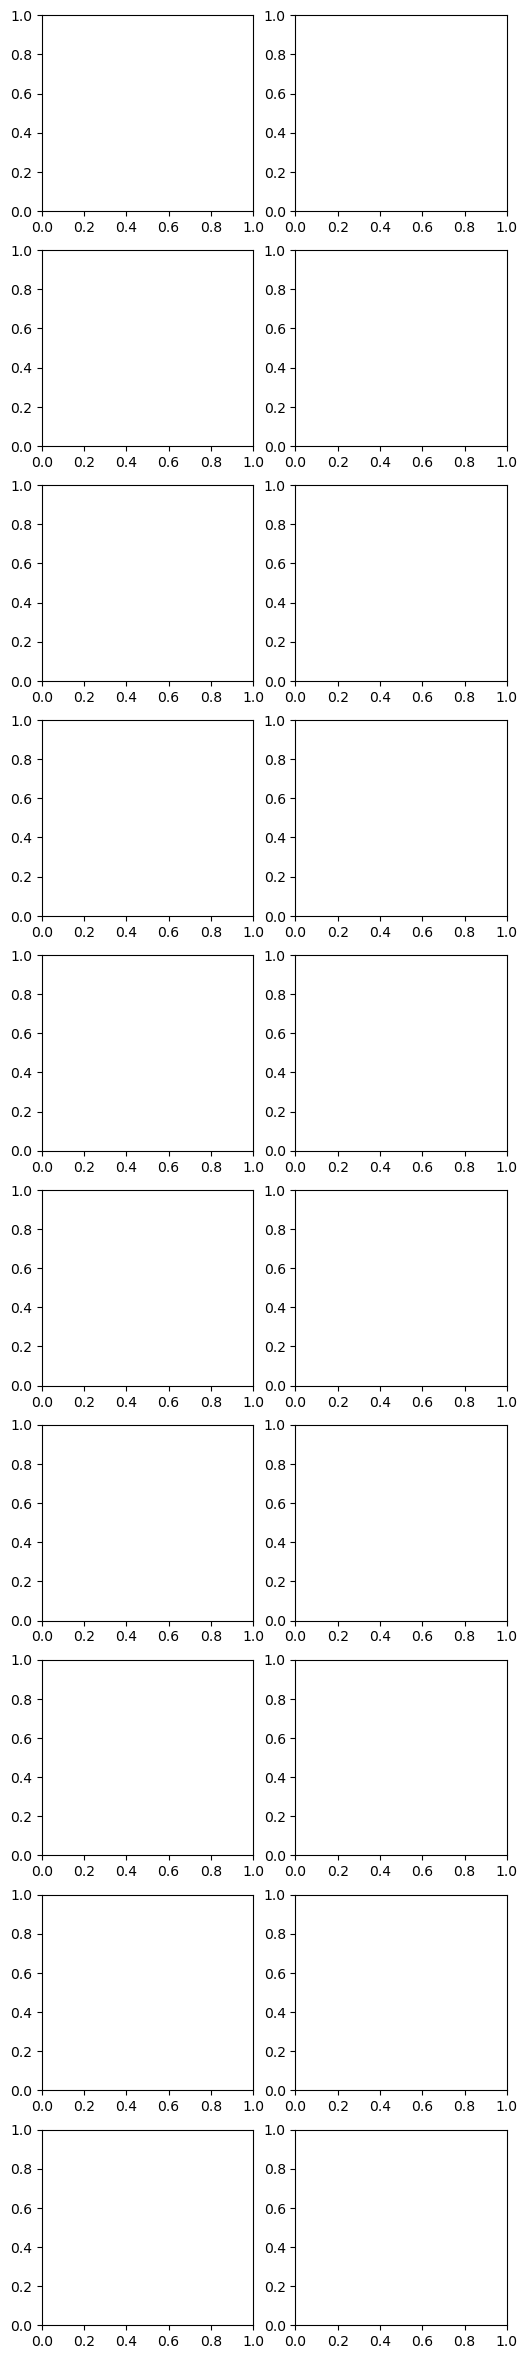

In [5]:
import matplotlib.pyplot as plt
import random
import torchvision.transforms.functional as F
from torchvision.io import read_image

# Sélection aléatoire de 10 chemins d'images
sample_df = test_df.sample(10, random_state=42)
sample_paths = [os.path.join(data_dir, fname) for fname in sample_df["img_file_name"]]
sample_labels = sample_df["object_annotation_category"].tolist()

# Figure
fig, axes = plt.subplots(10, 2, figsize=(6, 30))

for i, (path, label) in enumerate(zip(sample_paths, sample_labels)):
    # Lecture de l'image brute
    img = read_image(path)
    img_before = F.to_pil_image(img)

    # Transformation
    img_after = F.to_pil_image(train_transform(img))

    # Original
    axes[i, 0].imshow(img_before)
    axes[i, 0].set_title("Original", fontsize=12, fontweight='bold')
    axes[i, 0].text(
        0.5, -0.15, f"Label: {label}",
        fontsize=10, ha='center', va='top', transform=axes[i, 0].transAxes
    )
    axes[i, 0].axis("off")

    # Transformée
    axes[i, 1].imshow(img_after)
    axes[i, 1].set_title("Transformed", fontsize=12, fontweight='bold')
    axes[i, 1].text(
        0.5, -0.15, f"Label: {label}",
        fontsize=10, ha='center', va='top', transform=axes[i, 1].transAxes
    )
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

## Dataloading

In [8]:
# ---Create Dataloaders
batch_size = 32
n_cores = 8

log.info(f'Dataloading')

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_cores, pin_memory=True)
val_dataloader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=n_cores, pin_memory=True)
test_dataloader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=n_cores, pin_memory=True)

# ---Print infos
print(f"Nombre de classes : {len(class_to_idx)}")
print(f"Nombre de classes dans le valid set : {len(np.unique(val_labels))}")
print(f"Exemple de classes : {list(class_to_idx.keys())[:5]}")
print(f"Train batches : {len(train_dataloader)}, Val batches : {len(val_dataloader)}, Test batches : {len(test_dataloader)}")

dataloaders = {
    'train': train_dataloader,
    'valid': val_dataloader,
    'test': test_dataloader 
}

class_names = list(class_to_idx.keys())
n_classes= len(class_to_idx)

2025-12-18T13:38:13.367	Dataloading
2025-12-18T13:38:13.367	Dataloading


Nombre de classes : 30
Nombre de classes dans le valid set : 24
Exemple de classes : ['Actinopterygii', 'Amphipoda', 'Annelida', 'Brachyura', 'Chaetognatha']
Train batches : 2310, Val batches : 894, Test batches : 472


## Check the completness of your dataset

In [10]:
import os

def check_dataset_paths(dataset, name="dataset", max_display=5):
    """
    Vérifie que tous les chemins d'images du dataset existent.
    Affiche un résumé et quelques exemples de fichiers manquants.
    """
    print(f"🔍 Vérification des chemins pour {name} ...")

    missing = [p for p in dataset.paths if not os.path.exists(p)]

    if len(missing) == 0:
        print(f"✅ Tous les fichiers du {name} existent ({len(dataset.paths)} fichiers).")
    else:
        print(f"❌ {len(missing)} fichiers manquants sur {len(dataset.paths)} dans {name}.")
        print("Exemples de fichiers introuvables :")
        for p in missing[:max_display]:
            print("  -", p)
        print("💡 Vérifie ton data_dir ou la structure de tes chemins relatifs.")


In [11]:
check_dataset_paths(train_dataset, "train_dataset")
check_dataset_paths(val_dataset, "val_dataset")
check_dataset_paths(test_dataset, "test_dataset")

🔍 Vérification des chemins pour train_dataset ...
✅ Tous les fichiers du train_dataset existent (61521 fichiers).
🔍 Vérification des chemins pour val_dataset ...
✅ Tous les fichiers du val_dataset existent (14910 fichiers).
🔍 Vérification des chemins pour test_dataset ...
✅ Tous les fichiers du test_dataset existent (8819 fichiers).


# Start MLflow

In [9]:
print("torch.cuda.is_available():", torch.cuda.is_available())
print("Nombre de GPU:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Nom GPU:", torch.cuda.get_device_name(0))

torch.cuda.is_available(): True
Nombre de GPU: 1
Nom GPU: NVIDIA RTX 6000 Ada Generation


# Test the models

In [11]:
mlflow.set_experiment("Phase_testing_on_14401+14402")
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

models_to_train = ["mobilenet_v3_large", "efficientnet_v2", "pyramidnet", "resnet50"]
architectures = ["one_layer"]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for model_name in models_to_train:
    for arch in architectures:
        # Démarrer un run MLflow pour chaque combinaison modèle/architecture
        with mlflow.start_run(run_name=f"{model_name}_{arch}"):
            
            # --- Initialize model
            model = initialize_model(
                model_name, 
                n_classes, 
                arch, 
                target_params=600000, 
                activation_fct=nn.Hardswish(), 
                p_dropout=0.2
            )
            model = model.to(device)

            weight_sensitivity = 0.25
            class_weights = ((max_count / class_counts)**weight_sensitivity).to_numpy()
            
            # --- Path to best model - TO CHANGE
            best_model_path = os.path.join(train_dir, f"Final_training_smartbay_{model_name}.pt")
            
            # --- Define loss function (pas besoin d'optimizer pour le test)
            criterion = nn.CrossEntropyLoss(
                weight=torch.tensor(class_weights, dtype=torch.float32).to(device)
            )
            
 #           criterion = FocalLoss(
 #               gamma=gamma_loss,
 #              alpha=torch.tensor(class_weights).float().to(device),
 #              reduction='mean'
 #         )
            
            # --- Log hyperparameters
            mlflow.log_params({
                "model": model_name,
                "architecture": arch,
                "dataset": "14401+14402",
                "dropout": 0.2,
                "loss_criterion": "CrossEntropyLoss",
                "num_classes": n_classes
            })

            classes_to_remove = ["detritus", "filament<detritus", "artefact", "reflection", "dark<sphere", "Actinopterygii"]
            
            # --- Test model (sans optimizer)
            test_results = test_model(
                model, 
                dataloaders, 
                criterion, 
                best_model_path, 
                class_to_idx, 
                classes_to_remove, 
                n_classes, 
                device,
                num_epochs=1, 
                artf_path=f"{model_name}_{arch}"
            )
            
            # --- Log final test metrics as params (pour comparaison facile)
            mlflow.log_params({
                "final_test_accuracy": f"{test_results['accuracy']:.4f}",
                "final_test_f1": f"{test_results['f1_score']:.4f}"
            })
            
            # --- Log confusion matrix
            log_confusion_matrix(
                model=model,
                dataloader=dataloaders['test'],  # Utiliser dataloaders['test']
                device=device,
                class_names=list(class_to_idx.keys()),
                n_classes=n_classes,
                base_dir=base_dir
            )
            
            # --- Log the tested model
            mlflow.pytorch.log_model(
                model,
                artifact_path=f"{model_name}_{arch}"
            )
            
            log.info(f"Testing complete and logged for {model_name}_{arch}")
            log.info(f"Test Accuracy: {test_results['accuracy']:.4f}")
            log.info(f"Test F1: {test_results['f1_score']:.4f}")

log.info("All testing completed!")

2025-12-18T13:39:28.569	Start testing
2025-12-18T13:39:28.569	Start testing
2025-12-18T13:39:28.571	Loading best model from /home/coicaudtou/myspace/Classify_ANERIS/Outputs/output_training/Final_training_smartbay_mobilenet_v3_large.pt
2025-12-18T13:39:28.571	Loading best model from /home/coicaudtou/myspace/Classify_ANERIS/Outputs/output_training/Final_training_smartbay_mobilenet_v3_large.pt
/homedir/coicaudtou/Classify_ANERIS/Script/Testingmodels/Testing_models.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no lo

✅ Confusion matrix logged to MLflow


2025-12-18T13:40:36.419	Testing complete and logged for mobilenet_v3_large_one_layer
2025-12-18T13:40:36.419	Testing complete and logged for mobilenet_v3_large_one_layer
2025-12-18T13:40:36.420	Test Accuracy: 0.8176
2025-12-18T13:40:36.420	Test Accuracy: 0.8176
2025-12-18T13:40:36.421	Test F1: 0.3520
2025-12-18T13:40:36.421	Test F1: 0.3520


🏃 View run mobilenet_v3_large_one_layer at: http://192.168.77.70:6000/#/experiments/16/runs/83aebc747d234a92b110b6041c7aab41
🧪 View experiment at: http://192.168.77.70:6000/#/experiments/16


2025-12-18T13:40:37.079	Start testing
2025-12-18T13:40:37.079	Start testing
2025-12-18T13:40:37.083	Loading best model from /home/coicaudtou/myspace/Classify_ANERIS/Outputs/output_training/Final_training_smartbay_efficientnet_v2.pt
2025-12-18T13:40:37.083	Loading best model from /home/coicaudtou/myspace/Classify_ANERIS/Outputs/output_training/Final_training_smartbay_efficientnet_v2.pt
/homedir/coicaudtou/Classify_ANERIS/Script/Testingmodels/Testing_models.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer b

✅ Confusion matrix logged to MLflow


2025-12-18T13:43:30.499	Testing complete and logged for efficientnet_v2_one_layer
2025-12-18T13:43:30.499	Testing complete and logged for efficientnet_v2_one_layer
2025-12-18T13:43:30.500	Test Accuracy: 0.8302
2025-12-18T13:43:30.500	Test Accuracy: 0.8302
2025-12-18T13:43:30.501	Test F1: 0.5494
2025-12-18T13:43:30.501	Test F1: 0.5494


🏃 View run efficientnet_v2_one_layer at: http://192.168.77.70:6000/#/experiments/16/runs/8ec8f91682174f9d9d84a92e65cbfd0f
🧪 View experiment at: http://192.168.77.70:6000/#/experiments/16


/homedir/coicaudtou/Classify_ANERIS/Script/Loadingmodels/Loading_models.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(checkpoint_path, map_locati

✅ Confusion matrix logged to MLflow


2025-12-18T13:46:29.807	Testing complete and logged for pyramidnet_one_layer
2025-12-18T13:46:29.807	Testing complete and logged for pyramidnet_one_layer
2025-12-18T13:46:29.808	Test Accuracy: 0.8229
2025-12-18T13:46:29.808	Test Accuracy: 0.8229
2025-12-18T13:46:29.809	Test F1: 0.4647
2025-12-18T13:46:29.809	Test F1: 0.4647


🏃 View run pyramidnet_one_layer at: http://192.168.77.70:6000/#/experiments/16/runs/573fc442f7d44978b8f2108854c4974c
🧪 View experiment at: http://192.168.77.70:6000/#/experiments/16


2025-12-18T13:46:30.410	Start testing
2025-12-18T13:46:30.410	Start testing
2025-12-18T13:46:30.418	Loading best model from /home/coicaudtou/myspace/Classify_ANERIS/Outputs/output_training/Final_training_smartbay_resnet50.pt
2025-12-18T13:46:30.418	Loading best model from /home/coicaudtou/myspace/Classify_ANERIS/Outputs/output_training/Final_training_smartbay_resnet50.pt
/homedir/coicaudtou/Classify_ANERIS/Script/Testingmodels/Testing_models.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to b

✅ Confusion matrix logged to MLflow


2025-12-18T13:47:55.110	Testing complete and logged for resnet50_one_layer
2025-12-18T13:47:55.110	Testing complete and logged for resnet50_one_layer
2025-12-18T13:47:55.111	Test Accuracy: 0.8290
2025-12-18T13:47:55.111	Test Accuracy: 0.8290
2025-12-18T13:47:55.112	Test F1: 0.4800
2025-12-18T13:47:55.112	Test F1: 0.4800
2025-12-18T13:47:55.218	All testing completed!
2025-12-18T13:47:55.218	All testing completed!


🏃 View run resnet50_one_layer at: http://192.168.77.70:6000/#/experiments/16/runs/529d56bb9bdb47aab645f9bf01842df7
🧪 View experiment at: http://192.168.77.70:6000/#/experiments/16
